In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
plt.style.use('fivethirtyeight')
import pickle
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 150, 6

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')
df = pd.read_csv('/content/train.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
#print(len(df)
#plt.plot(df['speed']['2017-01-01 00:00:00':'2017-02-01 03:00:00'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


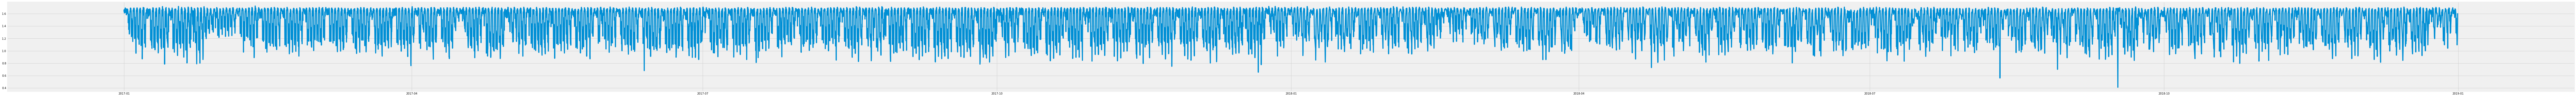

In [5]:
# change 5
plt.plot(np.log10(df['speed']))

In [10]:
# change 4
df.speed = np.log(df.speed)
#df

In [3]:
# change!!!!!!
avg = np.mean(df.speed)
avg

32.779117707331515

In [4]:
std = np.std(df.speed)
std

13.573328904046921

In [6]:
df.speed = (df.speed - avg)/std
#df

In [5]:
df

,id,speed
date,,
2017-01-01 00:00:00,0,43.002930
2017-01-01 01:00:00,1,46.118696
2017-01-01 02:00:00,2,44.294158
2017-01-01 03:00:00,3,41.067468
2017-01-01 04:00:00,4,46.448653
...,...,...
2018-12-31 12:00:00,14001,19.865269
2018-12-31 15:00:00,14002,17.820375
2018-12-31 16:00:00,14003,12.501851


In [6]:
_max = max(df.speed)
_max

53.16128631

### 数据预处理

In [ ]:
# # 滤波
# def filter(x):


In [3]:
# 归一化
def normalize(x):
  _max = np.max(x)
  _min = np.min(x)
  res = (x - _min) / (_max - _min)
  return _max, _min, res

In [4]:
_max, _min, df.speed = normalize(df.speed)

In [5]:
print(_max)
print(_min)
#df

53.16128631
2.573416855


### 十折交叉验证

In [7]:
data_train = []
data_test = []
num_fold = 10
length_fold = len(df)//num_fold
for i in range(num_fold):
  begin = i*length_fold
  end = begin + length_fold if i!=9 else len(df)
  data_test.append(df[begin:end])
  set_diff_df = pd.concat([df, df[begin:end], df[begin:end]]).drop_duplicates(keep=False)
  data_train.append(set_diff_df)
# print(data_train)

In [8]:
def create_features(df, label=None):
    df['date'] = df.index # index: DatetimeIndex
    df['hour'] = df['date'].dt.hour # dt: DatetimeProperties, hour: Series
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear

    X = df[['hour', 'day_of_week', 'quarter', 'month', 'day_of_year', 'day_of_month', 'week_of_year']]
    # X = df[['hour', 'day_of_week', 'day_of_year', 'day_of_month', 'week_of_year']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
# pip install catboost
import catboost as cb
from catboost import CatBoostRegressor

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
import lightgbm as lgb


best_i = 0
loss = 9999999
max_train = np.zeros(num_fold, dtype = int)
min_train = np.zeros(num_fold, dtype = int)
max_test = np.zeros(num_fold, dtype = int)
min_test = np.zeros(num_fold, dtype = int)
for i in range(num_fold):
  X_train, y_train = create_features(data_train[i], label='speed')
  X_test, y_test = create_features(data_test[i], label='speed')
  # y_train = y_train/_max
  # y_test = y_test/_max
  # 归一化
  # max_train[i], min_train[i], y_train = normalize(y_train)
  # y_test = (y_test - min_train[i]) / (max_train[i] - min_train[i])
  # max_test[i], min_test[i], y_test = normalize(y_test)
  #模型
  reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)
  # 训练（early_stopping_rounds：当准确率不再提高时，停止迭代）
  reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)
  y_pred = reg.predict(X_test)

  # 模型2
  # param = {'num_leaves':31, 'num_trees':100, 'objective':'regression'}
  #param = {'max_depth': 6, 'num_leaves': 50, 'num_trees':100, 'objective':'regression', 'iterations':1000, 'learning_rate':0.1, 'metric':'mse'}

  ### change !!!! result 7
  # data_train2 = lgb.Dataset(X_train, y_train, silent=True)
  # reg222 = lgb.train(param, data_train2)
  # y_pred = reg222.predict(X_test)

  # ## 模型3
  # reg222 = CatBoostRegressor(iterations=1000, learning_rate=0.02,eval_metric='RMSE', early_stopping_rounds=50)
  # reg222.fit(X_train, y_train)
  # y_pred = reg222.predict(X_test)


  new_loss = sum((y_pred - y_test)**2)/len(y_pred)
  print("=================================")
  print("(%d) MSE:%.8f"%(i, new_loss))
  if i==0 or new_loss < loss:
    pickle.dump(reg, open("/content/reg_best.dat", "wb"))
    loss = new_loss
    best_i = i
print(best_i)

[08:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.282	validation_1-rmse:33.6233
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:31.669	validation_1-rmse:32.0096
[2]	validation_0-rmse:30.1391	validation_1-rmse:30.4791
[3]	validation_0-rmse:28.6883	validation_1-rmse:29.0279
[4]	validation_0-rmse:27.3128	validation_1-rmse:27.652
[5]	validation_0-rmse:26.0088	validation_1-rmse:26.3479
[6]	validation_0-rmse:24.7731	validation_1-rmse:25.1121
[7]	validation_0-rmse:23.6023	validation_1-rmse:23.9411
[8]	validation_0-rmse:22.4933	validation_1-rmse:22.832
[9]	validation_0-rmse:21.4322	validation_1-rmse:21.7713
[10]	validation_0-rmse:20.4272	validation_1-rmse:20.7668
[11]	validation_0-rmse:19.4755	validation_1-rmse:19.8154
[12]	validation_0-rmse:18.5747	validation_1-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package s

[15]	validation_0-rmse:16.1523	validation_1-rmse:16.4954
[16]	validation_0-rmse:15.4311	validation_1-rmse:15.7783
[17]	validation_0-rmse:14.7494	validation_1-rmse:15.0977
[18]	validation_0-rmse:14.1057	validation_1-rmse:14.4581
[19]	validation_0-rmse:13.4979	validation_1-rmse:13.8515
[20]	validation_0-rmse:12.9246	validation_1-rmse:13.2823
[21]	validation_0-rmse:12.384	validation_1-rmse:12.7429
[22]	validation_0-rmse:11.8749	validation_1-rmse:12.2376
[23]	validation_0-rmse:11.3953	validation_1-rmse:11.7593
[24]	validation_0-rmse:10.942	validation_1-rmse:11.3103
[25]	validation_0-rmse:10.5178	validation_1-rmse:10.8873
[26]	validation_0-rmse:10.1195	validation_1-rmse:10.4867
[27]	validation_0-rmse:9.7423	validation_1-rmse:10.1131
[28]	validation_0-rmse:9.39085	validation_1-rmse:9.76263
[29]	validation_0-rmse:9.06101	validation_1-rmse:9.42983
[30]	validation_0-rmse:8.75235	validation_1-rmse:9.12113
[31]	validation_0-rmse:8.4606	validation_1-rmse:8.83277
[32]	validation_0-rmse:8.18935	vali

In [12]:
#_ = plot_importance(reg, height=0.9)

In [11]:
reg2 = pickle.load(open("/content/reg_best.dat", "rb"))
X_test, y_test = create_features(data_test[best_i], label='speed')

y_pred = reg2.predict(X_test)#*(max_train[best_i] - min_train[best_i])+min_train[best_i]
# print(np.exp(y_pred))
# print(np.exp(y_test))
# loss = sum(((y_pred*(_max - _min) - y_test*(_max - _min)))**2)/len(y_pred)
loss = sum((y_pred*std - y_test*std)**2)/len(y_pred)
# loss = sum((np.power(10, y_pred*_max) - np.power(10, y_test))**2)/len(y_pred)
# loss = sum((np.exp(y_pred*(_max - _min) +_min) - np.exp(y_test*(_max - _min) +_min))**2)/len(y_pred)

# loss = sum((np.exp(y_pred) - np.exp(y_test))**2)/len(y_pred)

print(loss)

[08:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2355.256281050095


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

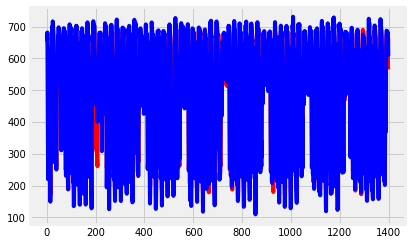

In [12]:
plt.plot(y_pred*std+avg, 'r', label='prediction')
plt.plot(y_test.values*std+avg, 'b', label='real')

In [13]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')
data_test2 = pd.read_csv('/content/test.csv', parse_dates=['date'],index_col='date',date_parser=dateparse)
print(data_test2.head())

                     id
date                   
2018-01-01 02:00:00   0
2018-01-01 05:00:00   1
2018-01-01 07:00:00   2
2018-01-01 08:00:00   3
2018-01-01 10:00:00   4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [14]:
X_test2 = create_features(data_test2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [16]:
# y_pred2 = np.exp(reg2.predict(X_test2))#*(max - min)+min
y_pred2 = reg2.predict(X_test2)
y_pred2

array([49.20265 , 48.688686, 35.513554, ..., 45.514214, 39.237957,
       41.8273  ], dtype=float32)

In [17]:
id = range(len(y_pred2))
ans = pd.DataFrame({'id':id,'speed':y_pred2}).set_index('id')
ans

,speed
id,
0,49.202648
1,48.688686
2,35.513554
3,24.987938
4,32.918564
...,...
3499,14.943959
3500,24.365883
3501,45.514214


In [19]:
ans.to_csv('/content/result_cv.csv')